# Experimentation in Action: Planning & Researching an ML Project

### Loading Libraries

In [43]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

# Scikit-Learn
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Time 
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Statistical Models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##### Setting Plot Standards

In [44]:
rcParams['figure.figsize'] = 16, 10

#### Retrieving Data

Data can be retrieved at `[acquired by cloning the repo at https://github.com/alan-turing-institute/TCPD.git]`

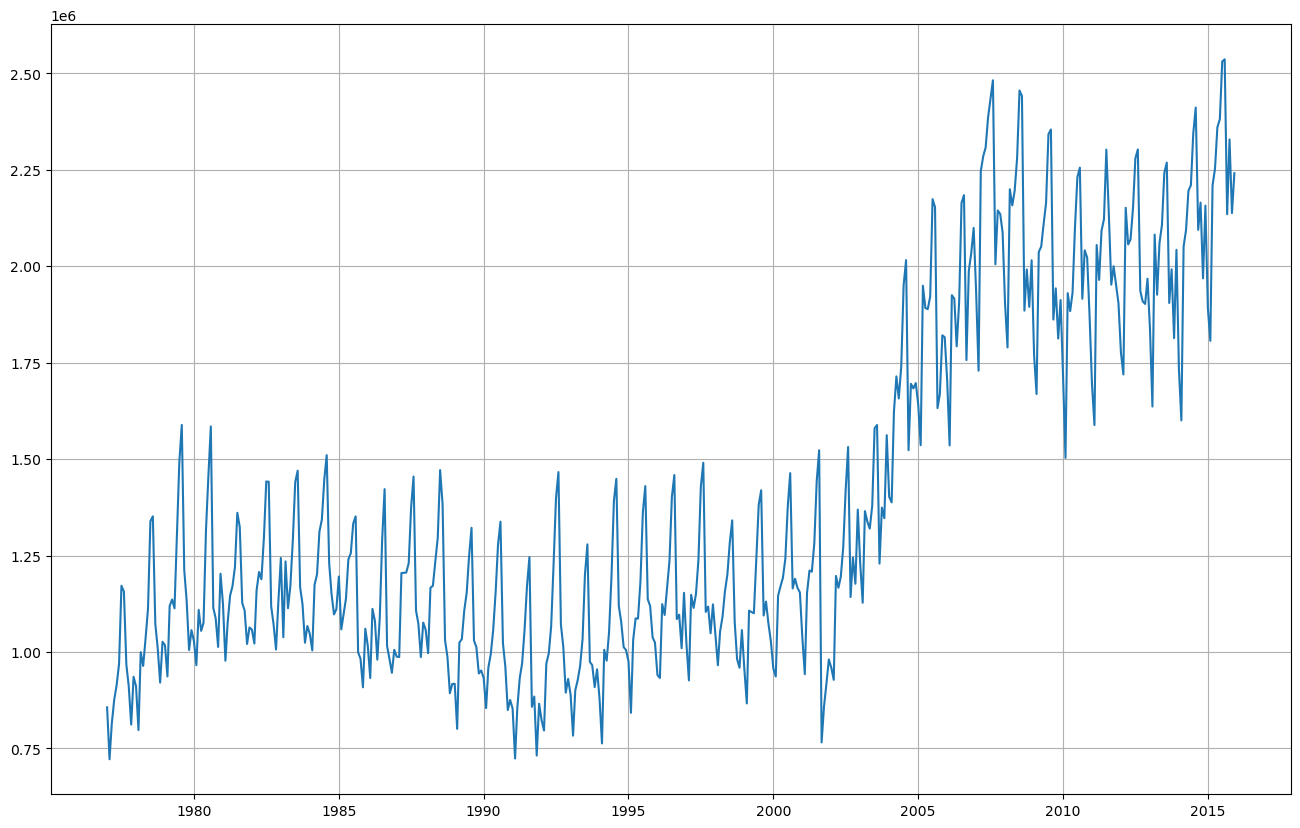

In [45]:
# Setting File Location
ts_file = '/Users/isisromero/desktop/MLEIA/chap_05/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

try:
    raw_data = pd.read_csv(ts_file)

    # Making a Shallow Copy
    raw_data = raw_data.copy(deep=False) 

    raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%b').dt.month 

    raw_data.loc[:, 'Day'] = 1 

    raw_data['date'] = pd.to_datetime(raw_data[['Year', 'Month', 'Day']])

    # Filtering out JFK data
    jfk_data = raw_data[raw_data['Airport Code'] == 'JFK'] 

    jfk_asc = jfk_data.sort_values('date', ascending=True) 

    jfk_asc.set_index('date', inplace=True) 

    # Plot the data in the most basic (default) way
    plt.plot(jfk_asc['Domestic Passengers'])
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print("File is not in the specified location")

#### ElasticNet from sklearn

In [46]:
# The old standby...
boston_data = datasets.load_boston() 

boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)

boston_df['House_Price'] = boston_data.target

x = boston_df.drop('House_Price', axis=1)
y = boston_df['House_Price']

# Splitting Data
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

# Setting Model 
lm_elastic = ElasticNet()

# Fitting Model
lm_elastic.fit(train_x, train_y)
predict_lm_elastic = lm_elastic.predict(test_x)

# Getting Scores
print('My score is:')
np.round(metrics.mean_squared_error(test_y, predict_lm_elastic))

My score is:


/Users/isisromero/anaconda3/envs/MLEIA/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Cali

25.0

My score is:
0.76


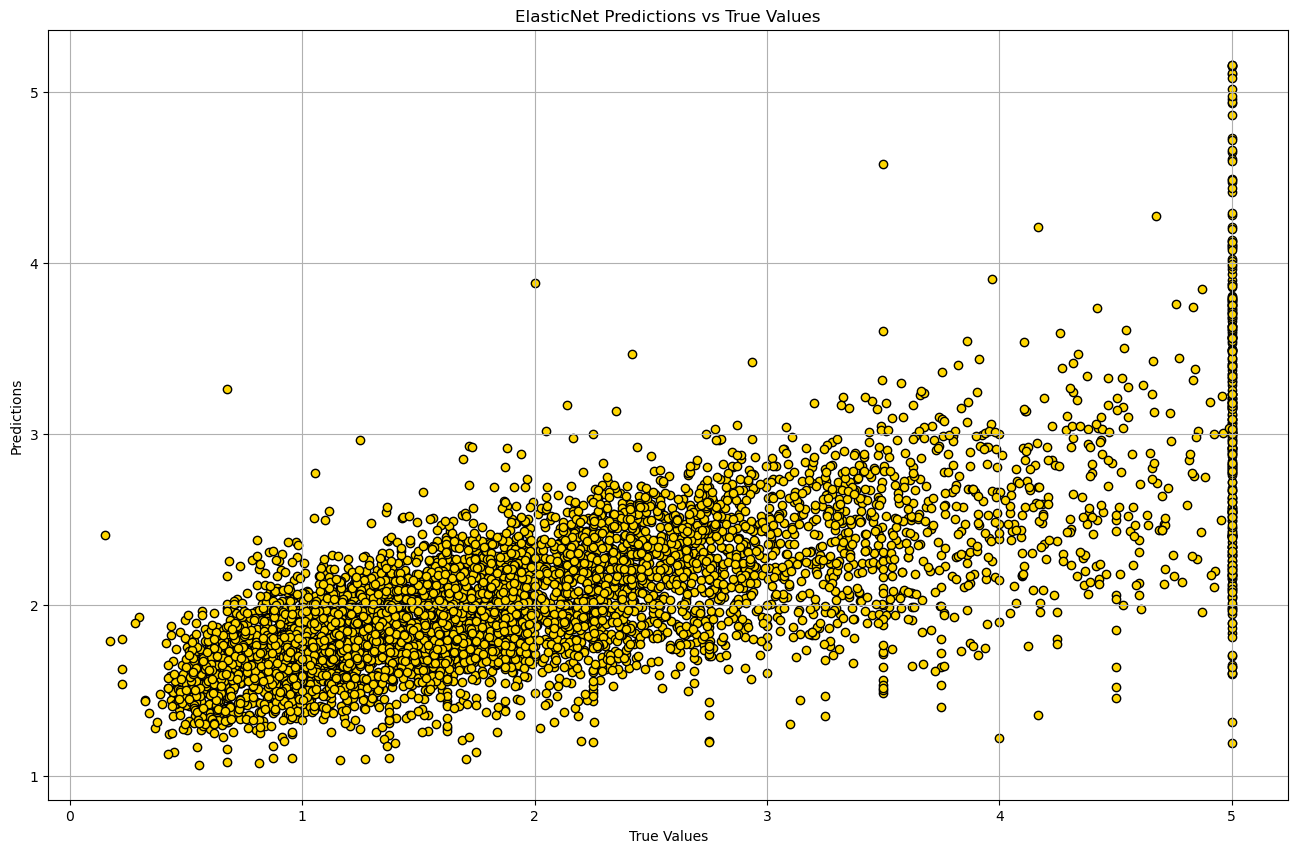

In [47]:
# Load the California housing dataset
from sklearn.datasets import fetch_california_housing
california_data = fetch_california_housing()

# Create a DataFrame
california_df = pd.DataFrame(california_data.data, columns=california_data.feature_names)
california_df['House_Price'] = california_data.target

# Define features and target
x = california_df.drop('House_Price', axis=1)
y = california_df['House_Price']

# Split the data
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

# Set up the model
lm_elastic = ElasticNet()

# Fit the model
lm_elastic.fit(train_x, train_y)
predict_lm_elastic = lm_elastic.predict(test_x)

# Get scores
print('My score is:')
mse = np.round(metrics.mean_squared_error(test_y, predict_lm_elastic), 2)
print(mse)

# Plot results
plt.scatter(test_y, predict_lm_elastic, color='gold', edgecolor='black')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("ElasticNet Predictions vs True Values")
plt.grid(True)
plt.show()

In [48]:
# On Parameters
elasticnet_regressor = ElasticNet(
  alpha=0.8,
  l1_ratio=0.6,
  fit_intercept=False,
  normalize=False,
  precompute=True,
  max_iter=5000,
  copy_X=True,
  tol=1e-6,
  warm_start=False,
  positive=True,
  random_state=42,
  selection='random'
)

#### Moving Average Trend with 2-Sigma Error

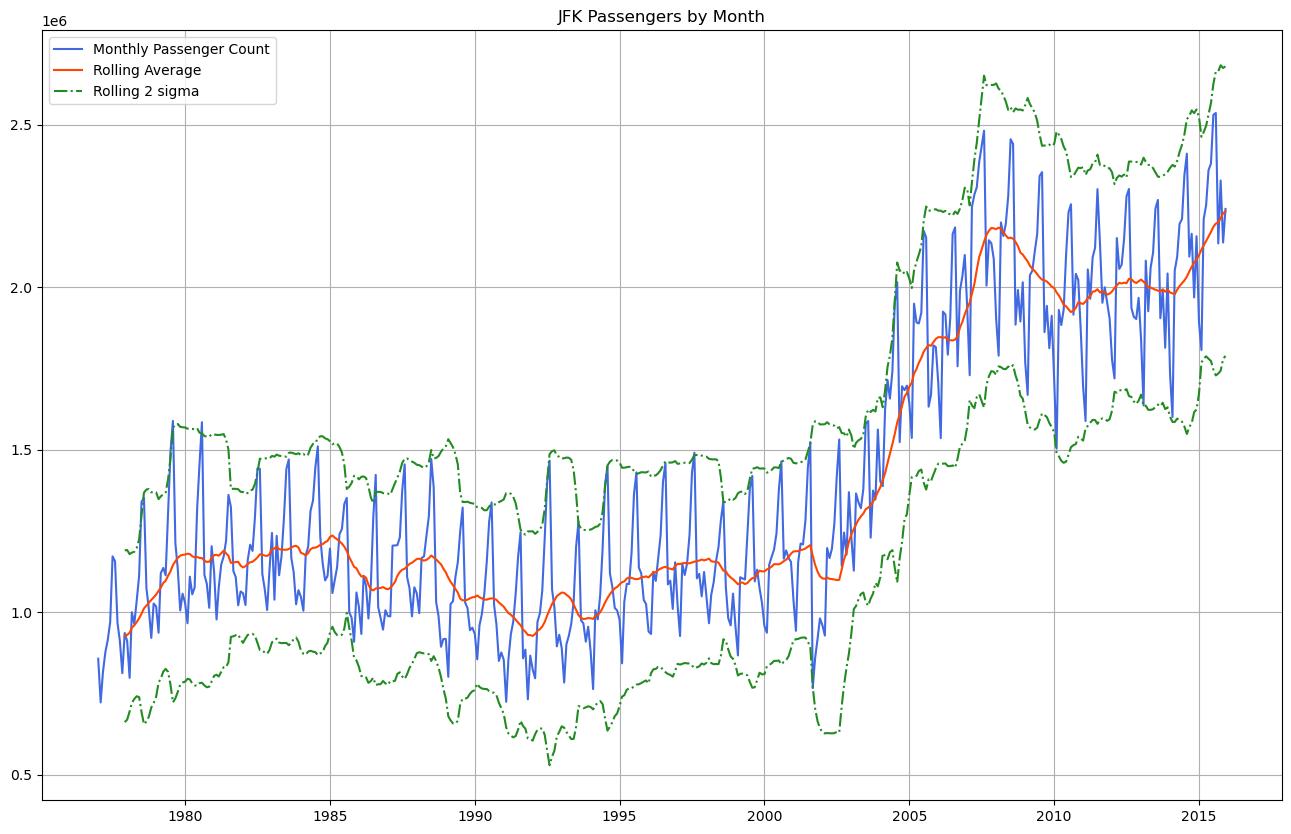

In [49]:
rolling_average = jfk_asc['Domestic Passengers'].rolling(12, center=False).mean()
rolling_std = jfk_asc['Domestic Passengers'].rolling(12, center=False).std()
plt.plot(jfk_asc['Domestic Passengers'], color='royalblue', label='Monthly Passenger Count')
plt.plot(rolling_average, color='orangered', label='Rolling Average')
plt.plot(rolling_average + (2 * rolling_std), color='forestgreen', linestyle='-.', label='Rolling 2 sigma')
plt.plot(rolling_average - (2 * rolling_std), color='forestgreen', linestyle='-.')
plt.legend(loc='best')
plt.title('JFK Passengers by Month')
plt.grid(True)
plt.show(block=False)

#### Stationarity Test for a Time Series

In [50]:
dickey_fuller_test = adfuller(jfk_asc['Domestic Passengers'], autolag='AIC')

test_items = dickey_fuller_test[:4]

report_items = test_items + (("not " if test_items[1] > 0.05 else "") + "stationary",)

df_report = pd.Series(report_items, 
                      index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationarity Test'])

for k, v in dickey_fuller_test[4].items(): 
    df_report['Critical Value(%s)' % k] = v
    
print(df_report)

Test Statistic              -0.049872
p-value                      0.954208
# Lags                             13
# Observations                    454
Stationarity Test      not stationary
Critical Value(1%)          -3.444836
Critical Value(5%)          -2.867927
Critical Value(10%)         -2.570172
dtype: object


#### Trend Decomposition for Seasonality

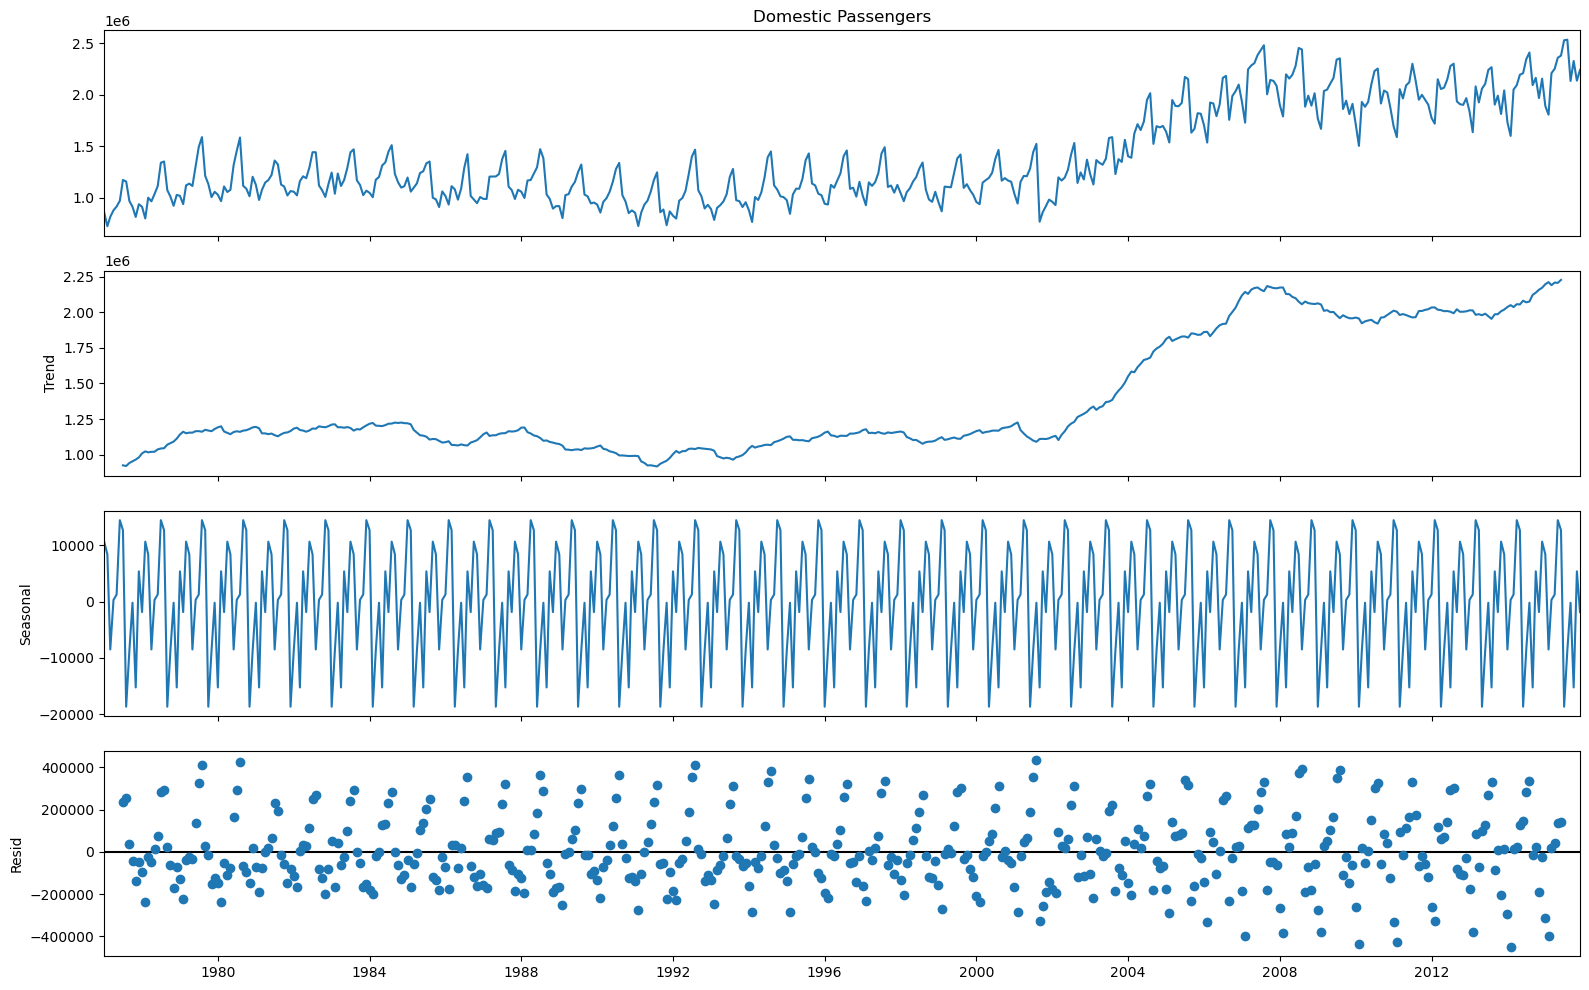

In [51]:
decomposed_trends = seasonal_decompose(jfk_asc['Domestic Passengers'], period=13)

trend_plot = decomposed_trends.plot()

plt.savefig("decomposed13.svg", format='svg')

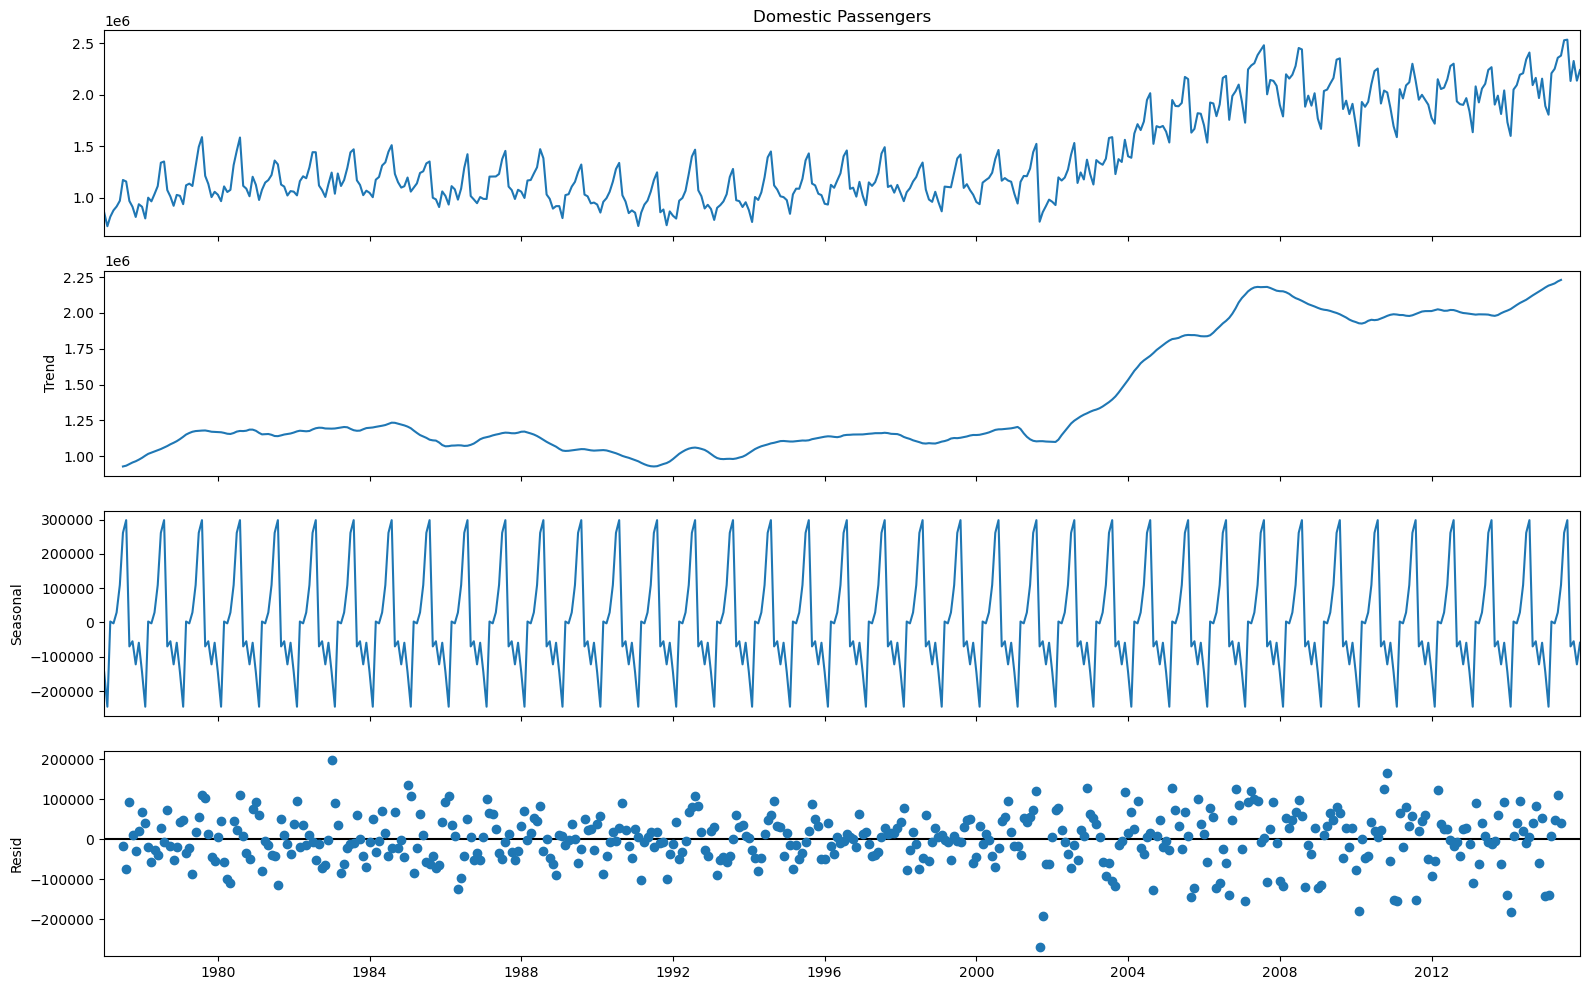

In [52]:
decomposed_trends_adj = seasonal_decompose(jfk_asc['Domestic Passengers'], period=12)

trend_plot = decomposed_trends_adj.plot()

plt.savefig("decomposed12.svg", format='svg')

#### Time Series Differencing Functions & Visualizations

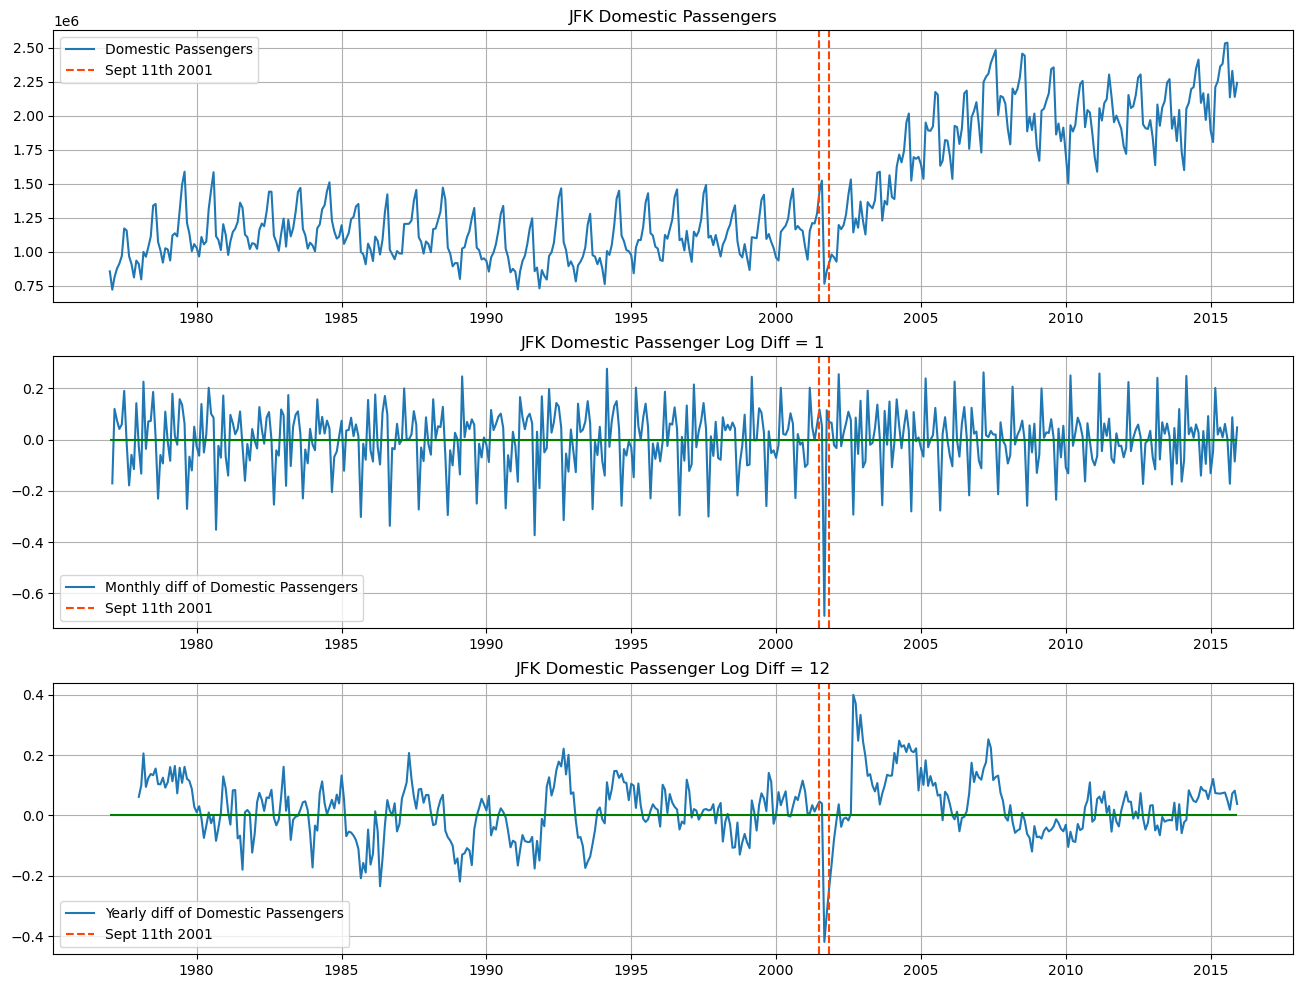

In [53]:
jfk_asc['Log Domestic Passengers'] = np.log(jfk_asc['Domestic Passengers'])
jfk_asc['DiffLog Domestic Passengers month'] = jfk_asc['Log Domestic Passengers'].diff(1)
jfk_asc['DiffLog Domestic Passengers year'] = jfk_asc['Log Domestic Passengers'].diff(12)

fig, axes = plt.subplots(3, 1, figsize=(16,12))

boundary1 = datetime.strptime('2001-07-01', '%Y-%m-%d')
boundary2 = datetime.strptime('2001-11-01', '%Y-%m-%d')

axes[0].plot(jfk_asc['Domestic Passengers'], '-', label='Domestic Passengers')
axes[0].set(title='JFK Domestic Passengers')
axes[0].axvline(boundary1, 0, 2.5e6, color='orangered', linestyle='--', label='Sept 11th 2001')
axes[0].axvline(boundary2, 0, 2.5e6, color='orangered', linestyle='--')
axes[0].grid(True)
axes[0].legend(loc='upper left')

axes[1].plot(jfk_asc['DiffLog Domestic Passengers month'], label='Monthly diff of Domestic Passengers')
axes[1].hlines(0, jfk_asc.index[0], jfk_asc.index[-1], 'g')
axes[1].set(title='JFK Domestic Passenger Log Diff = 1')
axes[1].axvline(boundary1, 0, 2.5e6, color='orangered', linestyle='--', label='Sept 11th 2001')
axes[1].axvline(boundary2, 0, 2.5e6, color='orangered', linestyle='--')
axes[1].grid(True)

axes[1].legend(loc='lower left')
axes[2].plot(jfk_asc['DiffLog Domestic Passengers year'], label='Yearly diff of Domestic Passengers')
axes[2].hlines(0, jfk_asc.index[0], jfk_asc.index[-1], 'g')
axes[2].set(title='JFK Domestic Passenger Log Diff = 12')
axes[2].axvline(boundary1, 0, 2.5e6, color='orangered', linestyle='--', label='Sept 11th 2001')
axes[2].axvline(boundary2, 0, 2.5e6, color='orangered', linestyle='--')
axes[2].legend(loc='lower left')
axes[2].grid(True)

plt.savefig("logdiff.svg", format='svg')

In [54]:
dickey_fuller_test_modded = adfuller(jfk_asc['Domestic Passengers'].diff(1).dropna(), autolag='AIC')

test_items_modded = dickey_fuller_test_modded[:4]

report_items_modded = test_items_modded + (("not " if test_items_modded[1] > 0.05 else "") + "stationary",)

df_report_modded = pd.Series(report_items_modded, 
                      index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationarity Test'])

for k, v in dickey_fuller_test_modded[4].items(): 
    df_report_modded['Critical Value(%s)' % k] = v

print(df_report_modded)

Test Statistic          -5.696968
p-value                  0.000001
# Lags                         12
# Observations                454
Stationarity Test      stationary
Critical Value(1%)      -3.444836
Critical Value(5%)      -2.867927
Critical Value(10%)     -2.570172
dtype: object


#### Data Ingestion & Formatting Functions

In [55]:
AIRPORT_FIELD = 'Airport Code'

def apply_index_freq(data, freq): 
    return data.asfreq(freq)

def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

def get_airport_data(airport, file_location): 
    all_data = pull_raw_airport_data(file_location)
    filtered = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered

def filter_airport_data(all_data, airport):
    filtered_data = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered_data

def get_all_airports(file_location): 
    all_data = pull_raw_airport_data(file_location)
    unique_airports = all_data[AIRPORT_FIELD].unique()
    return sorted(unique_airports)

#### Ingesting Data by Using a Reusable Function

In [56]:
DATA_PATH = '/Users/isisromero/desktop/MLEIA/chap_05/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

jfk = get_airport_data('JFK', DATA_PATH) 

jfk = apply_index_freq(jfk, 'MS') 

In [57]:
jfk

Airport Code  Year  Month  Domestic Passengers  \
1977-01-01          JFK  1977      1               856626   
1977-02-01          JFK  1977      2               722025   
1977-03-01          JFK  1977      3               813601   
1977-04-01          JFK  1977      4               876631   
1977-05-01          JFK  1977      5               913548   
...                 ...   ...    ...                  ...   
2015-08-01          JFK  2015      8              2535971   
2015-09-01          JFK  2015      9              2134468   
2015-10-01          JFK  2015     10              2328298   
2015-11-01          JFK  2015     11              2137376   
2015-12-01          JFK  2015     12              2240741   

            International Passengers  Total Passengers  Day  
1977-01-01                    630962           1487588    1  
1977-02-01                    515694           1237719    1  
1977-03-01                    636794           1450395    1  
1977-04-01                    732528           1609159    1  
1977-05-01                    810844           1724392    1  
...                              ...               ...  ...  
2015-08-01                   3273753           5809724    1  
2015-09-01                   2647629           4782097    1  
2015-10-01                   2571768           4900066    1  
2015-11-01                   2204682           4342058    1  
2015-12-01                   2456752           4697493    1  

[468 rows x 7 columns]

In [58]:
lga = apply_index_freq(get_airport_data('LGA', DATA_PATH) ,'MS')

lga

Airport Code  Year  Month  Domestic Passengers  \
1977-01-01          LGA  1977      1              1093062   
1977-02-01          LGA  1977      2              1020854   
1977-03-01          LGA  1977      3              1214632   
1977-04-01          LGA  1977      4              1257855   
1977-05-01          LGA  1977      5              1263020   
...                 ...   ...    ...                  ...   
2015-08-01          LGA  2015      8              2493267   
2015-09-01          LGA  2015      9              2192655   
2015-10-01          LGA  2015     10              2382229   
2015-11-01          LGA  2015     11              2210872   
2015-12-01          LGA  2015     12              2276138   

            International Passengers  Total Passengers  Day  
1977-01-01                         0           1093062    1  
1977-02-01                         0           1020854    1  
1977-03-01                         0           1214632    1  
1977-04-01                         0           1257855    1  
1977-05-01                         0           1263020    1  
...                              ...               ...  ...  
2015-08-01                    182041           2675308    1  
2015-09-01                    147775           2340430    1  
2015-10-01                    147655           2529884    1  
2015-11-01                    122683           2333555    1  
2015-12-01                    124345           2400483    1  

[468 rows x 7 columns]

#### Reusable Function for Visualizing Outlier Data

In [59]:
def generate_outlier_plots(data_series, series_name, series_column, event_date, event_name, image_name):
    
    # Differencing Stationary Functions Column Names
    log_name = 'Log {}'.format(series_column)
    month_log_name = 'DiffLog {} month'.format(series_column)
    year_log_name = 'DiffLog {} year'.format(series_column)
    
    # Setting to timetime object
    event_marker = datetime.strptime(event_date, '%Y-%m-%d').replace(day=1)
    
    two_month_delta = relativedelta(months=2)
    event_boundary_low = event_marker - two_month_delta
    event_boundary_high = event_marker + two_month_delta
    
    max_scaling = np.round(data_series[series_column].values.max() * 1.1, 0)
    
    data = data_series.copy(deep=True)
    
    # Adding Differencing Columns
    data[log_name] = np.log(data[series_column])
    data[month_log_name] = data[log_name].diff(1)
    data[year_log_name] = data[log_name].diff(12)
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    axes[0].plot(data[series_column], '-', label=series_column)
    axes[0].set(title='{} {}'.format(series_name, series_column))
    
    axes[0].axvline(event_boundary_low, 0, max_scaling, color='orangered', linestyle='--', label=event_name)
    axes[0].axvline(event_boundary_high, 0, max_scaling, color='orangered', linestyle='--')
    axes[0].legend(loc='best')
    axes[0].grid(True)
    
    axes[1].plot(data[month_log_name], label='Monthly diff of {}'.format(series_column))
    axes[1].hlines(0, data.index[0], data.index[-1], 'g')
    axes[1].set(title='{} Monthly diff of {}'.format(series_name, series_column))
    axes[1].axvline(event_boundary_low, 0, max_scaling, color='orangered', linestyle='--', label=event_name)
    axes[1].axvline(event_boundary_high, 0, max_scaling, color='orangered', linestyle='--')
    axes[1].legend(loc='best')
    axes[1].grid(True)
    
    axes[2].plot(data[year_log_name], label='Year diff of {}'.format(series_column))
    axes[2].hlines(0, data.index[0], data.index[-1], 'g')
    axes[2].set(title='{} Yearly diff of {}'.format(series_name, series_column))
    axes[2].axvline(event_boundary_low, 0, max_scaling, color='orangered', linestyle='--', label=event_name)
    axes[2].axvline(event_boundary_high, 0, max_scaling, color='orangered', linestyle='--')
    axes[2].legend(loc='best')
    axes[2].grid(True)
    
    plt.savefig(image_name, format='svg')
    
    return fig

#### Using Outlier Visualization Function

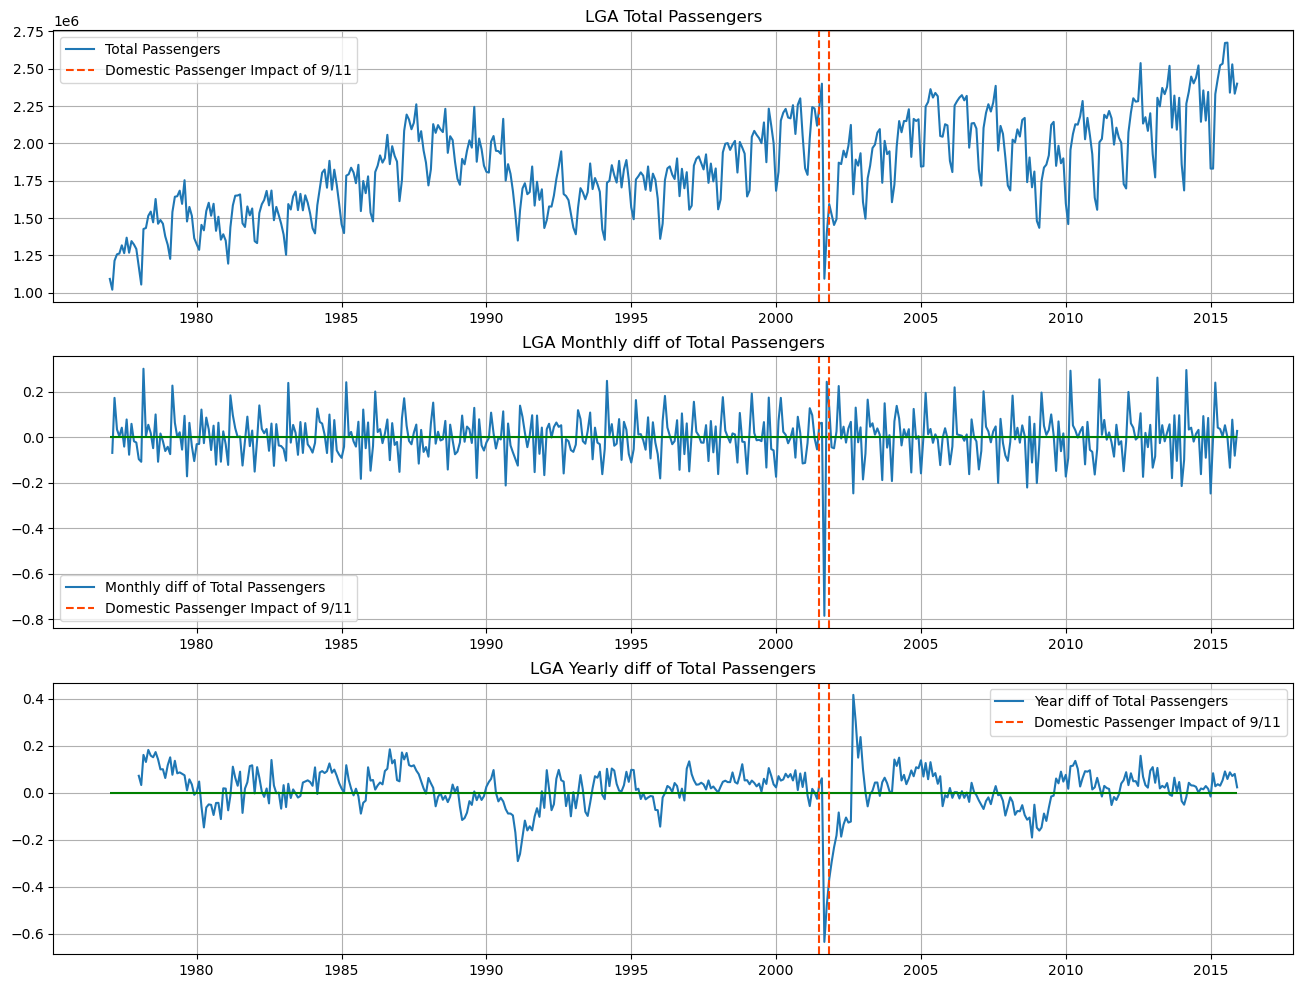

In [60]:
lga_data = apply_index_freq(get_airport_data('LGA', DATA_PATH), 'MS')

lga_outlier = generate_outlier_plots(lga_data, 'LGA', 'Total Passengers', '2001-09-11', 
                                     'Domestic Passenger Impact of 9/11', 'LaGuardiaImpactSep11.svg')

#### Experimental Phase Function use for Outlier Analysis

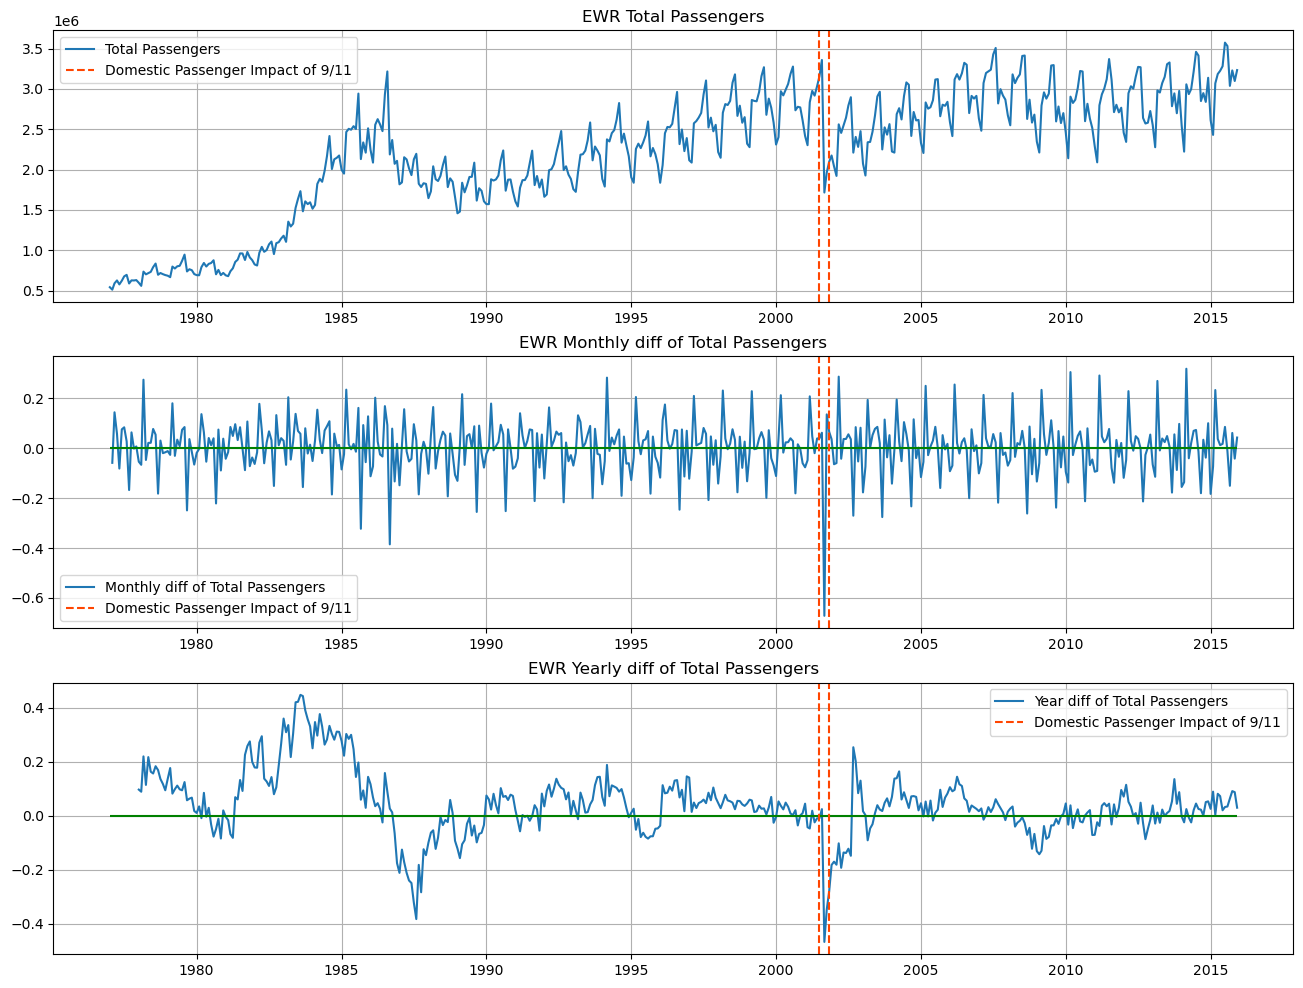

In [61]:
ewr_data = apply_index_freq(get_airport_data('EWR', DATA_PATH), 'MS')

ewr_outlier = generate_outlier_plots(ewr_data, 'EWR', 'Total Passengers', '2001-09-11', 
                                     'Domestic Passenger Impact of 9/11', 'NewarkImpactSep11.svg')

#### Standardized Time Series Visualization & Analysis for Model Preparation

In [62]:
def stationarity_tests(time_df, series_col, time_series_name, period, image_name, lags=12, cf_alpha=0.05, 
                       style='seaborn', plot_size=(16, 32)):
    log_col_name = 'Log {}'.format(series_col) 
    diff_log_col_name = 'LogDiff {}'.format(series_col) 
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diff_log_col_name] = time_df[log_col_name].diff()
    decomposed_trend = seasonal_decompose(time_df[series_col], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    
    with plt.style.context(style=style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[series_col], '-', label='Raw data for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw data trend for {}'.format(time_series_name)) 
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[0].grid(True)
        
        axes[1].plot(time_df[diff_log_col_name], 'g-', label='Log Diff for {}'.format(time_series_name))
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title('Diff Log Trend for outliers in {}'.format(time_series_name))
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        axes[1].grid(True)
        
        fig = plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        fig = plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[2].grid(True)

        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[3].grid(True)

        axes[4].plot(decomposed_trend.trend, 'r-', label='Trend data for {}'.format(time_series_name))
        axes[4].legend(loc='upper left')
        axes[4].set_title('Trend component of decomposition for {}'.format(time_series_name))
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[4].grid(True)

        axes[5].plot(decomposed_trend.seasonal, 'r-', label='Seasonal data for {}'.format(time_series_name))
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title('Seasonal component of decomposition for {}'.format(time_series_name))
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[5].grid(True)

        axes[6].plot(decomposed_trend.resid, 'r.', label='Residuals data for {}'.format(time_series_name))
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title('Residuals component of decomposition for {}'.format(time_series_name))
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
        axes[6].grid(True)
        
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
        
    return fig

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def stationarity_tests(time_df, series_col, time_series_name, period, image_name, lags=12, cf_alpha=0.05, 
                       style='seaborn-v0_8-darkgrid', plot_size=(16, 32)):
    log_col_name = 'Log {}'.format(series_col) 
    diff_log_col_name = 'LogDiff {}'.format(series_col) 
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diff_log_col_name] = time_df[log_col_name].diff()
    decomposed_trend = seasonal_decompose(time_df[series_col], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    
    with plt.style.context(style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[series_col], '-', label='Raw data for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw data trend for {}'.format(time_series_name)) 
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[0].grid(True)
        
        axes[1].plot(time_df[diff_log_col_name], 'g-', label='Log Diff for {}'.format(time_series_name))
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title('Diff Log Trend for outliers in {}'.format(time_series_name))
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        axes[1].grid(True)
        
        plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[2].grid(True)

        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[3].grid(True)

        axes[4].plot(decomposed_trend.trend, 'r-', label='Trend data for {}'.format(time_series_name))
        axes[4].legend(loc='upper left')
        axes[4].set_title('Trend component of decomposition for {}'.format(time_series_name))
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[4].grid(True)

        axes[5].plot(decomposed_trend.seasonal, 'r-', label='Seasonal data for {}'.format(time_series_name))
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title('Seasonal component of decomposition for {}'.format(time_series_name))
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[5].grid(True)

        axes[6].plot(decomposed_trend.resid, 'r.', label='Residuals data for {}'.format(time_series_name))
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title('Residuals component of decomposition for {}'.format(time_series_name))
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
        axes[6].grid(True)
        
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
        
    return fig

#### Trend Visualization for Newark Domestic Passengers

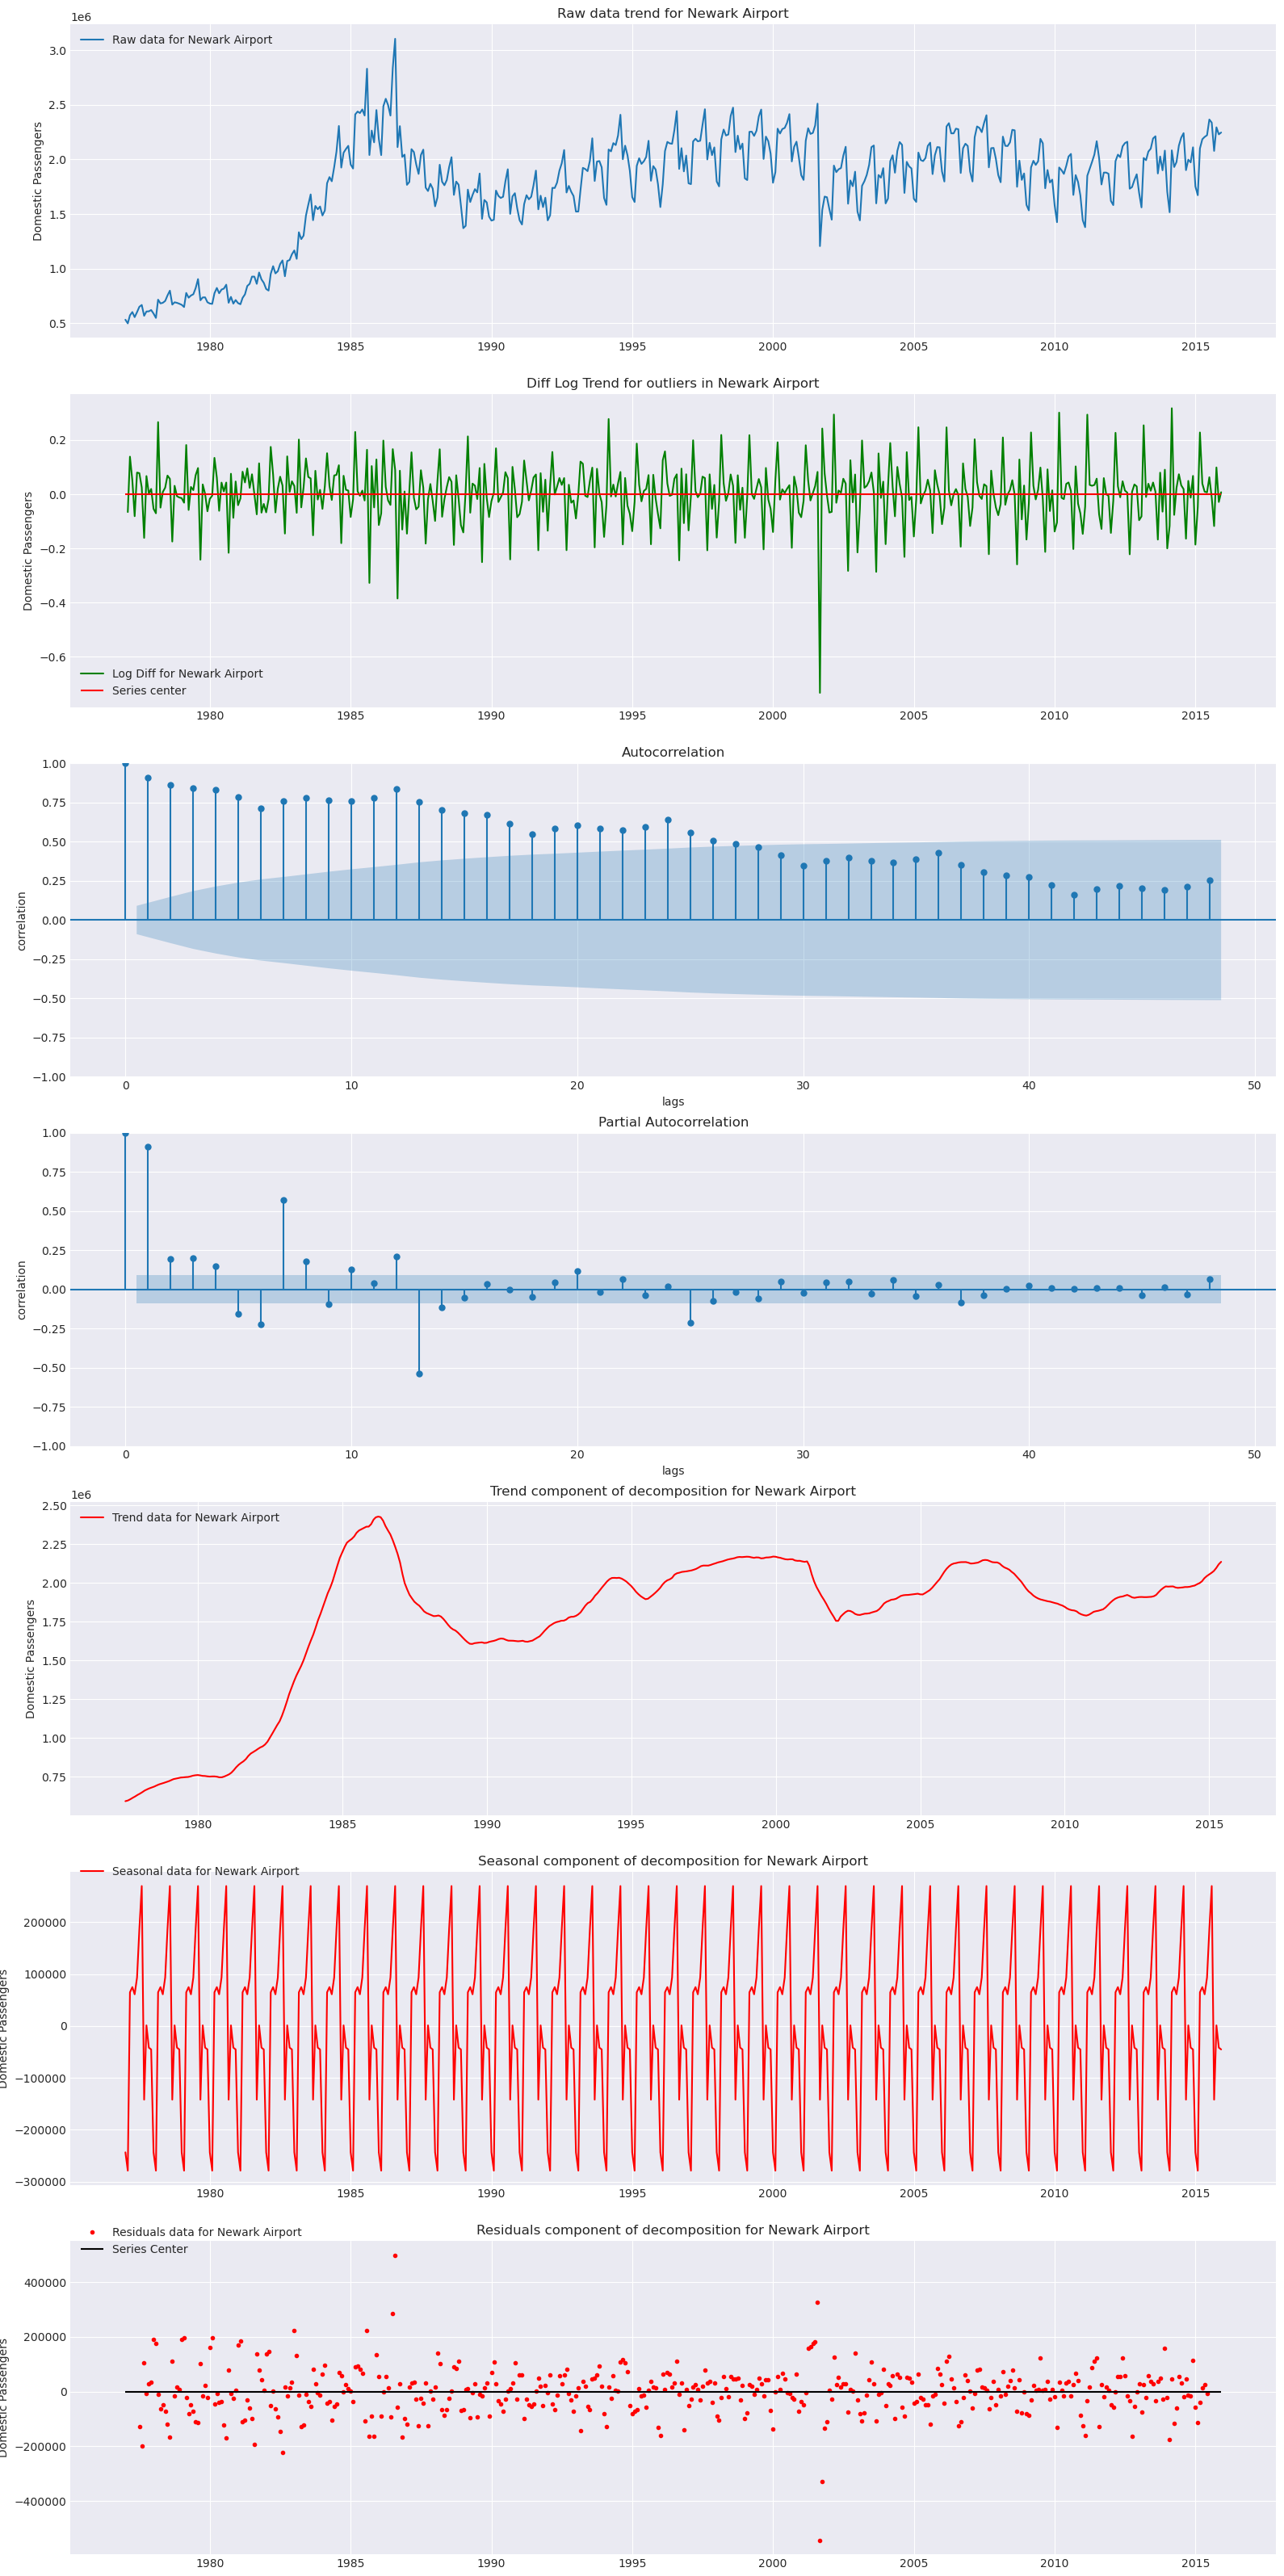

In [66]:
ewr_dom = apply_index_freq(get_airport_data('EWR', DATA_PATH), 'MS')

ewr_stationarity_plots = stationarity_tests(ewr_dom, 'Domestic Passengers', 
                                            'Newark Airport', 12, 'newark_domestic_plots.svg', 48, 0.05)